A notebook for creating code to analyze the k-means clustering of our experimental protein structures.

In [2]:
# from biopandas.pdb import PandasPdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial import distance_matrix
from statannotations.Annotator import Annotator
# from pymol import cmd
import scienceplots

In [3]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4], 'Obligate': pal[6]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [4]:
def num_clusters(df, max_d):
    uniprot = df['uniprot'].unique()
    array = df[['2_comp', 'complex_rmsd']].values

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def num_clusters_grmsd(df, max_d):
    '''
    df passed here must consist of the condensed distance matrix.
    '''

    uniprot = df['uniprot'].unique()
    array = np.reshape(df['complex_rmsd'].values, (len(df['complex_rmsd']), 1))

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def num_clusters_imfd(df, max_d):
    '''
    df passed here must consist of the condensed distance matrix.
    '''

    uniprot = df['uniprot'].unique()
    array = np.reshape(df['2_comp'].values, (len(df['2_comp']), 1))

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def produce_plot_dfs(ai_df, md_df, max_d, func):
    '''
    Take two dataframes, an autoinhibitory dataframe and a multi-domain dataframe, get the 
    number of clusters for each dataframe depending on the specified function, 
    and return a combined dataframe with the number of clusters
    '''

    ai_complex_clusters = pd.DataFrame()
    for uniprot in ai_df['uniprot'].unique():
        df = ai_df[ai_df['uniprot'] == uniprot].reset_index(drop=True)
        num_clusters_df = func(df, max_d)
        ai_complex_clusters = pd.concat([ai_complex_clusters, num_clusters_df])

    md_complex_clusters = pd.DataFrame()
    for uniprot in md_df['uniprot'].unique():
        df = md_df[md_df['uniprot'] == uniprot].reset_index(drop=True)
        num_clusters_df = func(df, max_d)
        md_complex_clusters = pd.concat([md_complex_clusters, num_clusters_df])

    ai_complex_clusters['type'] = 'Autoinhibitory'
    md_complex_clusters['type'] = 'Two-Domain'

    return pd.concat([ai_complex_clusters, md_complex_clusters])

def plot_clusters(df, ax):
    
    sns.boxplot(data=df, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
    ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set(xlabel=None, ylabel=None)
    pairs = [('Autoinhibitory', 'Two-Domain')]
    annotator = Annotator(ax=ax, pairs=pairs, data=df, x='type', y='num_clusters')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

In [5]:
ai = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
multiple_prots = ai['uniprot'].value_counts()
multiple_prots = multiple_prots[multiple_prots > 1].index
multiple = ai[ai['uniprot'].isin(multiple_prots)].reset_index(drop=True)
multiple.shape

(837, 16)

In [6]:
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t')
multiple_md = md['uniprot'].value_counts()
multiple_md = multiple_md[multiple_md > 1].index
multiple_md = md[md['uniprot'].isin(multiple_md)].reset_index(drop=True)
multiple_md.shape

(172, 29)

In [7]:
k = 2

ail = [multiple, multiple]
mdl = [multiple_md, multiple_md]
max_dl = [1, 3]
funcl = [num_clusters_grmsd, num_clusters_imfd]

ai_dfs = [ele for ele in ail for i in range(k)]
md_dfs = [ele for ele in mdl for i in range(k)]
max_ds = [ele for ele in max_dl for i in range(k)]
funcs = [ele for i in range(k) for ele in funcl]

dfs = [produce_plot_dfs(ai_dfs[i], md_dfs[i], max_ds[i], funcs[i]) for i in range(len(ai_dfs))]

/tmp/ipykernel_3582712/3447796206.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.456e-02 U_stat=1.274e+03


/tmp/ipykernel_3582712/3447796206.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.457e-02 U_stat=1.279e+03


/tmp/ipykernel_3582712/3447796206.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.025e-01 U_stat=1.102e+03


/tmp/ipykernel_3582712/3447796206.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.497e-02 U_stat=1.210e+03


<Figure size 4200x3150 with 0 Axes>

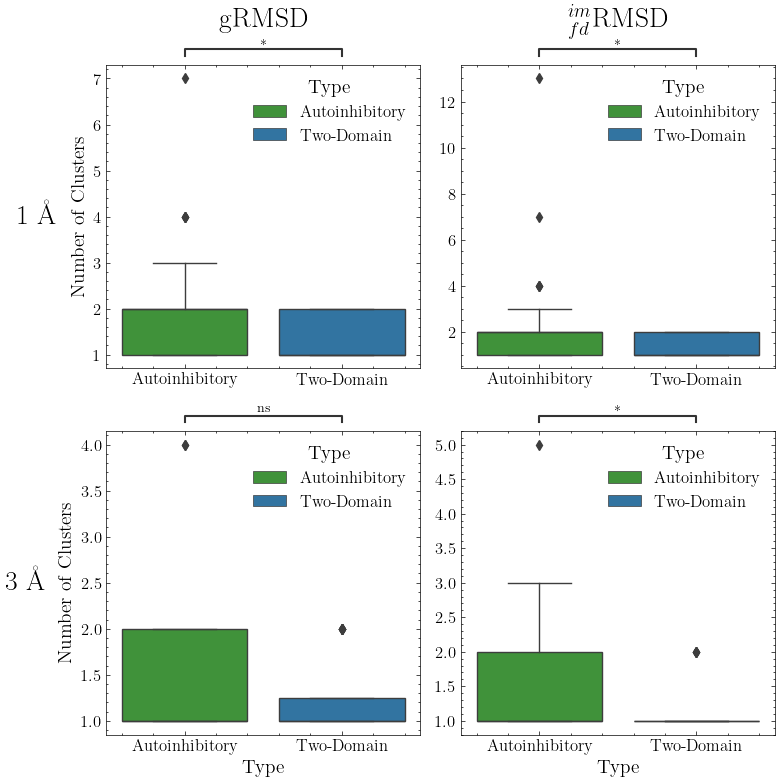

In [8]:
plt.figure(dpi=1200)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

dfs_axes = zip(dfs, axes.flatten())

for df, ax in dfs_axes:
    plot_clusters(df, ax)

cols = ['gRMSD', '$_{fd}^{im}$RMSD']
rows = ['1 Å', '3 Å']

pad = 5
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')
    
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Number of Clusters', fontsize=14)

for ax in axes[1]:
    ax.set_xlabel('Type', fontsize=14)

plt.tight_layout()

plt.savefig('./project_pipeline/data/figures/num_clusters.png')

In [9]:
ai_num_clusters = pd.DataFrame()

for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters(df, 2)
    ai_num_clusters = pd.concat([ai_num_clusters, num_clusters_df])

In [10]:
md_num_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters(df, 2)
    md_num_clusters = pd.concat([md_num_clusters, num_clusters_df])

In [11]:
ai_num_clusters['type'] = 'Autoinhibitory'
md_num_clusters['type'] = 'Two-Domain'

plot = pd.concat([ai_num_clusters, md_num_clusters]).reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.215e-02 U_stat=1.228e+03


/tmp/ipykernel_3582712/3079706561.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Number of Clusters', ylabel='num_clusters'>,
 [<statannotations.Annotation.Annotation at 0x7f400bcdfc10>])

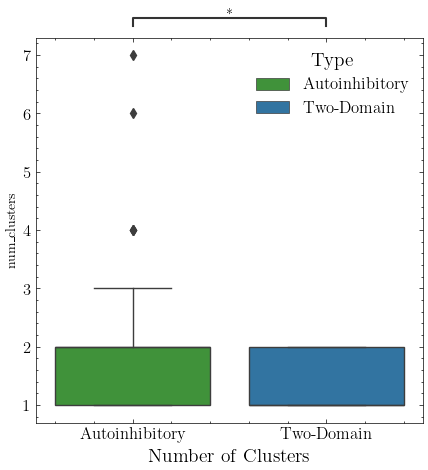

In [12]:
perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibitory', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [13]:
ai_complex_clusters = pd.DataFrame()
for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters_grmsd(df, 2)
    ai_complex_clusters = pd.concat([ai_complex_clusters, num_clusters_df])
ai_complex_clusters

,uniprot,num_clusters
0,P04637,1
0,P07038,2
0,Q8NQJ3,2
0,P00579,2
0,P60240,2
...,...,...
0,Q3KK31,1
0,P31016,1
0,Q9JK66,2
0,P53042,1


In [14]:
md_complex_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters_grmsd(df, 2)
    md_complex_clusters = pd.concat([md_complex_clusters, num_clusters_df])

ai_complex_clusters['type'] = 'Autoinhibitory'
md_complex_clusters['type'] = 'Two-Domain'

complex_plot = pd.concat([ai_complex_clusters, md_complex_clusters]).reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.367e-01 U_stat=1.155e+03


/tmp/ipykernel_3582712/3302377762.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Number of Clusters', ylabel='num_clusters'>,
 [<statannotations.Annotation.Annotation at 0x7f400b9a3990>])

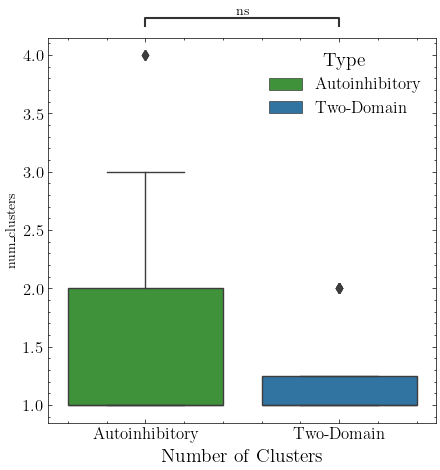

In [15]:
# perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=complex_plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibitory', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=complex_plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [16]:
ai_imfd_clusters = pd.DataFrame()

for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    ai_num_clusters = num_clusters_imfd(df, 3)
    ai_imfd_clusters = pd.concat([ai_imfd_clusters, ai_num_clusters])

md_imfd_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    md_num_clusters = num_clusters_imfd(df, 3)
    md_imfd_clusters = pd.concat([md_imfd_clusters, md_num_clusters])

ai_imfd_clusters['type'] = 'Autoinhibitory'
md_imfd_clusters['type'] = 'Two-Domain'

imfd_plot = pd.concat([ai_imfd_clusters, md_imfd_clusters]).reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Autoinhibitory vs. Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.497e-02 U_stat=1.210e+03


/tmp/ipykernel_3582712/2863877867.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


(<Axes: xlabel='Number of Clusters', ylabel='num_clusters'>,
 [<statannotations.Annotation.Annotation at 0x7f400b7f2dd0>])

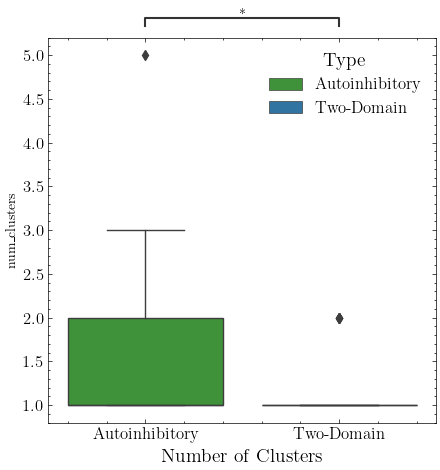

In [17]:
# perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=imfd_plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibitory', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=imfd_plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()